# Sentiment Analysis Review Produk

Download library Sastrawi untuk stemming text berbahasa indonesia

In [1]:
!pip install Sastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.8 MB/s eta 0:00:00


Import library-library yang dibutuhkan

In [2]:
import nltk
from nltk.corpus import stopwords as sw
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import csv
import zipfile
import re
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Upload file menggunakan method bawaan google colab

In [3]:
from google.colab import files

uploaded = files.upload()

Saving dataset review produk.zip to dataset review produk.zip


Ekstrak file zip yang telah diupload ke direktori yang telah ditentukan

In [4]:
zip_path = '/content/dataset review produk.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset review produk')

Melihat contoh text dari dataset

In [5]:
file_path = '/content/dataset review produk/Product Reviews Dataset for Emotions Classification Tasks - Indonesian (PRDECT-ID) Dataset/PRDECT-ID Dataset.csv'

with open(file_path, 'r') as csvfile:
    print(f'Header terlihat seperti berikut:\n\n{csvfile.readline()}')
    print(f'Text terlihat seperti berikut:\n\n{csvfile.readline()}')

Header terlihat seperti berikut:

Category,Product Name,Location,Price,Overall Rating,Number Sold,Total Review,Customer Rating,Customer Review,Sentiment,Emotion

Text terlihat seperti berikut:

Computers and Laptops,"Wireless Keyboard i8 Mini TouchPad Mouse 2.4G Handheld PC Android TV",Jakarta Utara,53500,4.9,5449,2369,5,"Alhamdulillah berfungsi dengan baik. Packaging aman. Respon cepat dan ramah. Seller dan kurir amanah",Positive,Happy



## Pre-processing Text

Membuat function `regex_preprocess()` untuk menghilangkan angka beserta tanda baca dan spasi tambahan

In [6]:
def regex_preprocess(sentence):
  sentence = re.sub(r'[^a-zA-Z\s]', ' ', sentence)
  sentence = re.sub(r'\s+', ' ', sentence)

  return sentence

Membuat function `remove_stopwords()` untuk menghilangkan stopwords dan stemming text

In [7]:
stop_words = set(sw.words('indonesian'))
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def remove_stopwords_and_stemming(sentence):
  sentence = sentence.lower()
  words = sentence.split()
  words = [word for word in words if word.lower() not in stop_words]
  filtered_words = [stemmer.stem(word) for word in words]
  sentence = " ".join(filtered_words)
  return sentence

Membuat function `parse_data_from_file()` untuk menguraikan text dari dataset dan dimasukkan kedalam sebuah list

In [8]:
def parse_data_from_file(filename):
  categories = []
  sentences = []
  labels = []
  with open(filename, 'r') as csvfile:\

    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for item in reader:
      categories.append(item[0])
      sentence = regex_preprocess(item[8])
      sentences.append(remove_stopwords_and_stemming(sentence))
      labels.append(item[9])
  return categories, sentences, labels

Mengimplementasikan function function yang dibuat diatas

In [9]:
categories, sentences, labels = parse_data_from_file(file_path)
print(f'Berikut adalah kategori dari text dibawah :\n{categories[0]}\n')
print(f'Berikut adalah contoh teks yang sudah dibersihkan :\n{sentences[0]}\n')
print(f'Ini adalah label teks diatas : {labels[0]}\n')
print(f'Ini adalah total label yang ada : {list(set(labels))}')

Berikut adalah kategori dari text dibawah :
Computers and Laptops

Berikut adalah contoh teks yang sudah dibersihkan :
alhamdulillah fungsi packaging aman respon cepat ramah seller kurir amanah

Ini adalah label teks diatas : Positive

Ini adalah total label yang ada : ['Positive', 'Negative']


Cek total text pada dataset

In [10]:
print(f'Total kalimat yang ada pada dataset : {len(sentences)}')
print(f'Total label yang ada pada dataset : {len(labels)}')

Total kalimat yang ada pada dataset : 5400
Total label yang ada pada dataset : 5400


Membagi dataset untuk training dan testing

In [11]:
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, train_size=0.95)

Cek total text pada dataset training dan testing

In [12]:
print(f'Total training set : {len(X_train)}')
print(f'Total test set : {len(X_test)}')
print(f'Total training labels : {len(y_train)}')
print(f'Total test labels : {len(y_test)}')

Total training set : 5130
Total test set : 270
Total training labels : 5130
Total test labels : 270


Menentukan hyperparameter

In [13]:
NUM_WORDS = 10000
EMBEDDING_DIM = 16
MAXLEN = 16
TRUNCATING = 'post'
PADDING = 'post'
OOV_TOKEN = "<OOV>"

Membuat function `fit_tokenizer()` untuk tokenisasi text yang kemudian dikonversi ke representasi angka agar bisa dimasukkan kedalam model untuk training

In [14]:
def fit_tokenizer(sentences, oov_token):
  tokenizer = Tokenizer(oov_token=oov_token)
  tokenizer.fit_on_texts(sentences)

  return tokenizer

Membuat function `pad_trunc_sequences()` untuk text yang sudah ditokenisasi agar menjadi sebuah sequences

In [15]:
def pad_trunc_sequences(sentences, tokenizer, padding, truncating, maxlen):
  sequences = tokenizer.texts_to_sequences(sentences)
  pad_trunc_sequences = pad_sequences(sequences, maxlen=maxlen, padding=padding, truncating=truncating)

  return pad_trunc_sequences

Membuat function `tokenize_labels()` untuk tokenisasi dan mengubahnya menjadi sequences khusus untuk label

In [16]:
def tokenize_labels(labels, split_labels):
  label_tokenizer = Tokenizer()
  label_tokenizer.fit_on_texts(labels)
  word_index = label_tokenizer.word_index

  label_seq = label_tokenizer.texts_to_sequences(split_labels)
  label_seq = np.array(label_seq) - 1

  return word_index, label_seq

Mengimplementasikan function `fit_tokenizer()` diatas

In [17]:
tokenizer = fit_tokenizer(X_train, OOV_TOKEN)

Mengimplementasikan function `pad_trunc_sequences()` dan `tokenize_labels()` diatas

In [18]:
train_padded_seq = pad_trunc_sequences(X_train, tokenizer, PADDING, TRUNCATING, MAXLEN)
test_padded_seq = pad_trunc_sequences(X_test, tokenizer, PADDING, TRUNCATING, MAXLEN)
train_label_wodex, train_label_seq = tokenize_labels(labels, y_train)
test_label_wodex, test_label_seq = tokenize_labels(labels, y_test)

Cek bentuk dan contoh training text yang sudah ditokenisasi

In [19]:
print(f'Berikut adalah shape dari training text yang sudah ditokenisasi: {train_padded_seq.shape}\n')
print(f'Berikut adalah shape dari test text yang sudah ditokenisasi: {test_padded_seq.shape}\n')
print(f'Berikut adalah 3 contoh dari training text yang sudah ditokenisasi:\n{train_padded_seq[:3]}\n')
print(f'Berikut adalah 3 contoh dari test text yang sudah ditokenisasi:\n{test_padded_seq[:3]}\n')

Berikut adalah shape dari training text yang sudah ditokenisasi: (5130, 16)

Berikut adalah shape dari test text yang sudah ditokenisasi: (270, 16)

Berikut adalah 3 contoh dari training text yang sudah ditokenisasi:
[[  20   22    7    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [  78   59    7  114  130   25   18   40   25    0    0    0    0    0
     0    0]
 [ 545   97  193    3   35  696 2965    0    0    0    0    0    0    0
     0    0]]

Berikut adalah 3 contoh dari test text yang sudah ditokenisasi:
[[ 364  521  239    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 120  116  165    9 1709   24  204    0    0    0    0    0    0    0
     0    0]
 [   2  456   33    1    0    0    0    0    0    0    0    0    0    0
     0    0]]



Looping untuk menyamakan index label dengan `word_index` dari label

In [20]:
for label in train_label_wodex:
  train_label_wodex[label] -= 1

Cek total label, bentuk dan contoh dari label yang sudah ditokenisasi

In [21]:
print(f'Berikut adalah index dan value dari label yang sudah ditokenisasi : {train_label_wodex}\n')
print(f'Berikut adalah shape dari training label yang sudah ditokenisasi: {train_label_seq.shape}\n')
print(f'Berikut adalah shape dari test label yang sudah ditokenisasi: {test_label_seq.shape}\n')
print(f'Berikut adalah 5 contoh dari training label yang sudah ditokenisasi:\n{train_label_seq[:5]}\n')
print(f'Berikut adalah 5 contoh dari test label yang sudah ditokenisasi:\n{test_label_seq[:5]}\n')

Berikut adalah index dan value dari label yang sudah ditokenisasi : {'negative': 0, 'positive': 1}

Berikut adalah shape dari training label yang sudah ditokenisasi: (5130, 1)

Berikut adalah shape dari test label yang sudah ditokenisasi: (270, 1)

Berikut adalah 5 contoh dari training label yang sudah ditokenisasi:
[[1]
 [0]
 [0]
 [1]
 [0]]

Berikut adalah 5 contoh dari test label yang sudah ditokenisasi:
[[0]
 [0]
 [1]
 [0]
 [1]]



Mengahpus variabel yang sudah tidak digunakan

In [22]:
del train_label_wodex, test_label_wodex

## Build and train model

Membuat function `create_model()` yang membuat model menggunakan Sequential Api

In [48]:
def create_model(num_words, embedding_dim, maxlen):
  model = tf.keras.Sequential([
      tf.keras.layers.Embedding(num_words, embedding_dim, input_length=maxlen),
      tf.keras.layers.GlobalAveragePooling1D(),
      tf.keras.layers.Reshape((16, 1), input_shape = (16, )),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  return model

Mengimplementasikan function diatas dan melihat ringkasan model yang telah dibuat

In [49]:
model = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)
model.summary()
tf.keras.backend.clear_session()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 16, 16)            160000    
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 reshape (Reshape)           (None, 16, 1)             0         
                                                                 
 bidirectional (Bidirection  (None, 16, 512)           528384    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 16, 512)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 16, 128)           2

Training model

In [50]:
history = model.fit(train_padded_seq, train_label_seq, epochs=20, validation_data=(test_padded_seq, test_label_seq))

Epoch 1/20
161/161 [==============================] - 41s 184ms/step - loss: 0.4781 - accuracy: 0.7335 - val_loss: 0.3783 - val_accuracy: 0.8407
Epoch 2/20
161/161 [==============================] - 28s 173ms/step - loss: 0.1974 - accuracy: 0.9232 - val_loss: 0.2746 - val_accuracy: 0.9074
Epoch 3/20
161/161 [==============================] - 28s 176ms/step - loss: 0.1310 - accuracy: 0.9579 - val_loss: 0.2921 - val_accuracy: 0.8926
Epoch 4/20
161/161 [==============================] - 29s 180ms/step - loss: 0.0896 - accuracy: 0.9686 - val_loss: 0.3578 - val_accuracy: 0.8926
Epoch 5/20
161/161 [==============================] - 29s 178ms/step - loss: 0.0907 - accuracy: 0.9686 - val_loss: 0.3263 - val_accuracy: 0.8741
Epoch 6/20
161/161 [==============================] - 28s 176ms/step - loss: 0.0743 - accuracy: 0.9721 - val_loss: 0.3495 - val_accuracy: 0.8815
Epoch 7/20
161/161 [==============================] - 28s 176ms/step - loss: 0.0595 - accuracy: 0.9789 - val_loss: 0.4383 - val_ac

## Evaluate model

Membuat function `create_plot()` untuk memplot hasil training model

In [51]:
def create_plot(history, string):
  plt.plot(history.history[string], 'r', label='Training '+string)
  plt.plot(history.history['val_'+string], 'b', label='Validation '+string)
  plt.title('Training and validation '+string)
  plt.legend()
  plt.show()
  print('')

Mengimplementasikan function diatas

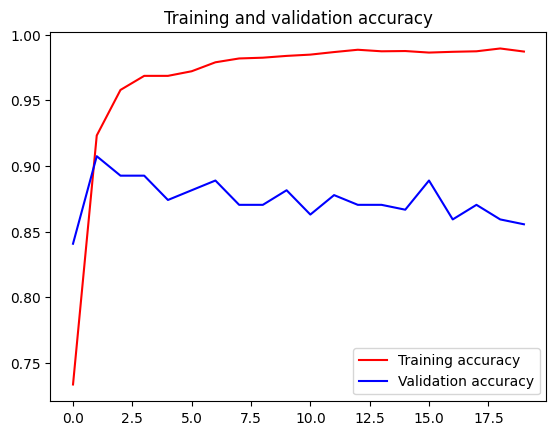

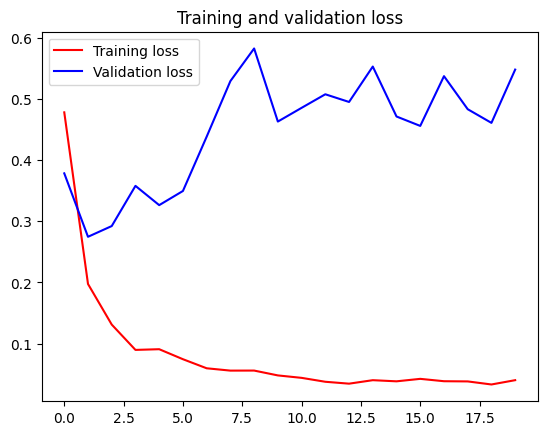

In [52]:
create_plot(history, 'accuracy')
create_plot(history, 'loss')

Menyimpan model yang telah ditrain ke format HDF5

In [53]:
model.save('sentiment analysis model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Evaluasi model menggunakan dataset testing

In [54]:
loss, accuracy = model.evaluate(test_padded_seq, test_label_seq)

print(f'\nLoss: {loss}')
print(f'Accuracy: {accuracy}')

9/9 [==============================] - 0s 41ms/step - loss: 0.5480 - accuracy: 0.8556

Loss: 0.5480131506919861
Accuracy: 0.855555534362793


Memprediksi text yang diinput menggunakan model yang telah dibuat

In [57]:
input_text = input('Masukkan text sentimen: ')

print('Text yang dimasukkan adalah :', input_text)

input_text = regex_preprocess(input_text)
input_text = remove_stopwords_and_stemming(input_text)

input_seq = tokenizer.texts_to_sequences([input_text])
input_padded = pad_sequences(input_seq, maxlen=MAXLEN, padding=PADDING, truncating=TRUNCATING)

predictions = model.predict(input_padded)

if predictions[0][0] > 0.5:
  print('Text tersebut memiliki sentimen positif')
else:
  print('Text tersebut memiliki sentimen negatif')

Masukkan text sentimen: barangnya bagus, harganya murah namun kualitasnya sangat baik
Text yang dimasukkan adalah : barangnya bagus, harganya murah namun kualitasnya sangat baik
1/1 [==============================] - 0s 37ms/step
Text tersebut memiliki sentimen positif
